In [5]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
#rom xgboost import XGBClassifier
import tqdm

In [6]:
df = pd.read_csv('./jigsaw-unintended-bias-in-toxicity-classification/train.csv')

In [7]:
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


[]

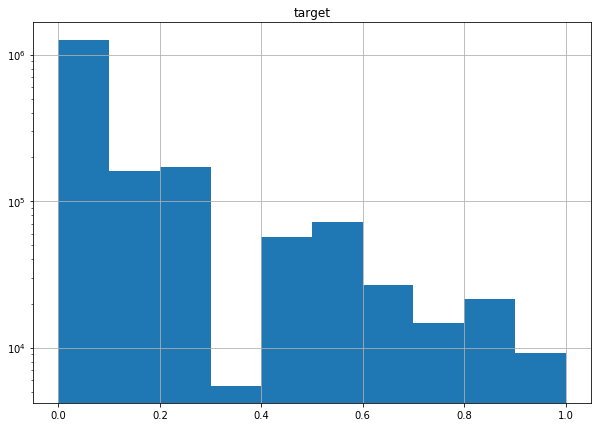

In [8]:
fig,ax = plt.subplots(figsize=(10,7))
df.hist('target',ax=ax)
ax.semilogy()

In [9]:
qualifier_cols = ['target','severe_toxicity', 'obscene',
'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
'jewish', 'latino', 'male', 'muslim', 'other_disability',
'other_gender', 'other_race_or_ethnicity', 'other_religion',
'other_sexual_orientation', 'physical_disability',
'psychiatric_or_mental_illness', 'transgender', 'white']

In [10]:
toxicity_aggregate = {}
toxicity_count_features = {}
for col in qualifier_cols:
    if col != 'toxicity':
        toxicity_aggregate[col] = df[df[col] > 0 ].target.mean()
        
for col in qualifier_cols:
    if col != 'toxicity':
        toxicity_count_features[col] = df[df[col] > 0 ].target.count()

    
correlations = df[qualifier_cols].corr()

In [43]:
print('feature row count',toxicity_count_features)

feature row count {'target': 540110, 'severe_toxicity': 104636, 'obscene': 147175, 'identity_attack': 218552, 'insult': 454539, 'threat': 106929, 'asian': 10975, 'atheist': 2253, 'bisexual': 3330, 'black': 19563, 'buddhist': 1366, 'christian': 61360, 'female': 73690, 'heterosexual': 3453, 'hindu': 1557, 'homosexual_gay_or_lesbian': 15307, 'intellectual_or_learning_disability': 2648, 'jewish': 10905, 'latino': 6936, 'male': 80179, 'muslim': 26650, 'other_disability': 3545, 'other_gender': 2723, 'other_race_or_ethnicity': 18867, 'other_religion': 16732, 'other_sexual_orientation': 4508, 'physical_disability': 3227, 'psychiatric_or_mental_illness': 10665, 'transgender': 6120, 'white': 29948}


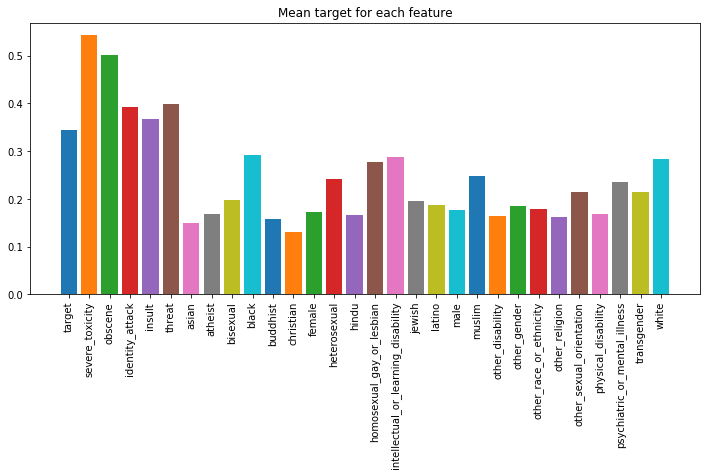

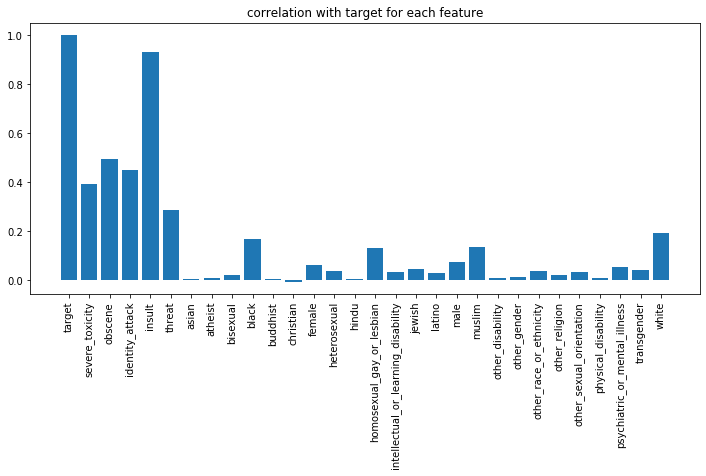

In [12]:
fig  = plt.subplots(figsize=(12,5))
for key,value in toxicity_aggregate.items():
    plt.bar(x='{}'.format(key),height=value)
plt.xticks(rotation=90)
plt.title('Mean target for each feature')
plt.show()


fig  = plt.subplots(figsize=(12,5))
plt.bar(x=correlations.index.tolist(),height=correlations['target'])
plt.xticks(rotation=90)
plt.title('correlation with target for each feature')
plt.show()

## Filtering by lgbt

In [13]:
# Get positive rows
df_lgbt_pos = df[df.homosexual_gay_or_lesbian > 0]
lends = df_lgbt_pos.shape[0]

In [14]:
# sample classes eqally from non toxic examples
not_toxic = df[(df.target == 0 ) & (df.homosexual_gay_or_lesbian == 0)].sample(lends,replace=False)

In [15]:
dflgbt = pd.concat([df_lgbt_pos,not_toxic])
dflgbt = dflgbt.sample(frac=1).reset_index(drop=True) # shffle df

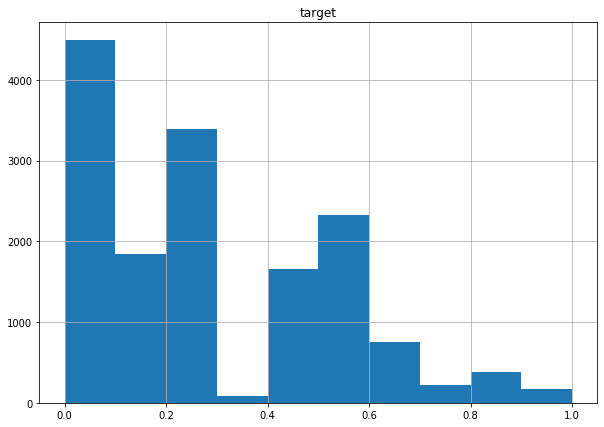

In [16]:
fig,ax = plt.subplots(figsize=(10,7))
df_lgbt_pos.hist('target',ax=ax)
plt.show()

In [17]:
## Using TF-IDF embeddings

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
TFIDF = np.asarray(vectorizer.fit_transform(dflgbt['comment_text']).todense())
print(vectorizer.get_feature_names()[-10:])
print(TFIDF.shape)

['yeah', 'year', 'years', 'yes', 'york', 'young', 'younger', 'youth', 'youtube', 'zero']
(30614, 2000)


In [28]:
Labels = (dflgbt.target > 0).astype(int)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(TFIDF, Labels, test_size=0.2, random_state=42)

## Logistic regression on single feature without dim reduction

In [21]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
ypred_train = clf.predict(X_train)
#clf.predict_proba(X_train) 


### Classification Metrics

In [22]:
print(classification_report(y_train, ypred_train))


              precision    recall  f1-score   support

           0       0.87      0.92      0.89     15859
           1       0.83      0.75      0.79      8632

    accuracy                           0.86     24491
   macro avg       0.85      0.84      0.84     24491
weighted avg       0.86      0.86      0.86     24491



In [23]:
ypred_test = clf.predict(X_test)
print(classification_report(y_test, ypred_test))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3932
           1       0.79      0.71      0.75      2191

    accuracy                           0.83      6123
   macro avg       0.82      0.80      0.81      6123
weighted avg       0.83      0.83      0.83      6123



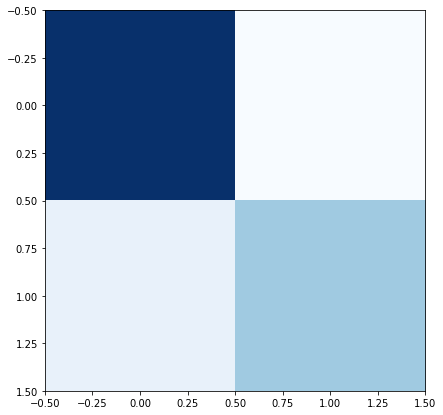

In [24]:
fig,ax = plt.subplots(figsize=(7,7))
cm = confusion_matrix(y_test, ypred_test)
plt.imshow(cm.astype('float')/cm.sum(),cmap = plt.cm.Blues)

## Logistic regression on single feature with dim reduction
## PCA reduction does not seem to help in this case

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca_TFIDF_train = pca.fit_transform(X_train)
pca_TFIDF_test = pca.fit_transform(X_test)
#pca.inverse_transform(pca.transform(X[8:]))

#small = pca_TFIDF[:1000]
#plt.plot(small[:,0],small[:,1],'+');


In [55]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(pca_TFIDF_train, y_train)
ypred_train = clf.predict(pca_TFIDF_train)
ypred_train
ypred_test = clf.predict(pca_TFIDF_test)
ypred_train

array([1, 0, 0, ..., 0, 1, 0])

In [56]:
print(classification_report(y_test, ypred_test))

              precision    recall  f1-score   support

           0       0.73      0.83      0.78      3932
           1       0.60      0.45      0.52      2191

    accuracy                           0.70      6123
   macro avg       0.66      0.64      0.65      6123
weighted avg       0.68      0.70      0.68      6123



### Use on another protected class

In [60]:
# Get positive rows
df_black = df[df.black > 0]
lends = df_black.shape[0]

# sample classes eqally from non toxic examples
not_toxic = df[(df.target == 0 ) & (df.black == 0)].sample(lends,replace=False)

dfrace = pd.concat([df_black,not_toxic])
dfrace = dfrace.sample(frac=1).reset_index(drop=True) # shffle df

In [62]:
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
TFIDF = np.asarray(vectorizer.fit_transform(dflgbt['comment_text']).todense())
Labels = (dflgbt.target > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(TFIDF, Labels, test_size=0.2, random_state=42)

In [66]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
ypred_train = clf.predict(X_train)
ypred_test = clf.predict(X_test)


In [67]:
print(classification_report(y_test, ypred_test))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3932
           1       0.79      0.71      0.75      2191

    accuracy                           0.83      6123
   macro avg       0.82      0.80      0.81      6123
weighted avg       0.83      0.83      0.83      6123

